### This script implements a simple spectral subtraction algorithm. After setting the variables, you may click "Runtime > Run all" (if you use Colab) or click the "Run All" button (if you use Visual Studio Code) to run all cells in one operation.

## Procedures
1. Read the codes in this .ipynb file to understand how they work.
1. Run all cells. Listen to the audio of (1) the noisy speech and (2) the denoised speech.
1. Modify the variable '*alpha*' to see its effect on the denoised speech.
1. Try other speech files and repeat Steps 2 and 3.

## Answer the following questions
1. Identify the regions in the spectrogram of the denoised speech that correspond to the musical noise.
1. Explain why spectral subtraction causes musical noise in the denoised speech.
1. Identify the artifact and explain why such artifact exists when '*alpha*' is very large, say *alpha=3'.
1. Explain why adding a noise floor to the denoised signal can help alleviate the artifact in (3).
1. Will adding a small amount of background noise to the denoised signal help alleviating the musical noise? Try it by modifying the program.
1. Explain why spectral subraction is not good at removing the machine-gun noise.


In [777]:
import matplotlib.pyplot as plt
import numpy as np
import librosa
from IPython.display import Audio

In [ ]:
# Define some variables and constants
use_colab = 'False'
infile = '../AudioFiles/noisy_speech2.wav'
alpha = 2                   # Over-subtraction factor
frame_size = 512
frame_shift = 64
noise_dur = 0.5             # Duration at the beginning of file considered as noise

In [ ]:
# Mount Google Drive and create a folder for the lab exercise
if use_colab == True:
  from google.colab import drive
  drive.mount('/content/drive')
  !mkdir -p /content/drive/MyDrive/Learning/EIE4435/Programs
  %cd /content/drive/MyDrive/Learning/EIE4435/Programs

In [779]:
# Function for plotting speech signal and its spectrogram
def plot_speech(x, sr=8000, frm_len=512, hop_len=256):
    X = librosa.amplitude_to_db(np.abs(librosa.stft(x, n_fft=frm_len, hop_length=hop_len)), ref=np.max)  # STFT of x
    _, ax = plt.subplots(nrows=2, sharex=True, figsize=(8,4))
    librosa.display.waveshow(x, sr=sr, ax=ax[0])
    librosa.display.specshow(X, sr=sr, n_fft=frm_len, hop_length=hop_len, x_axis='time', y_axis='linear', ax=ax[1])

In [780]:
def specsub(y, frame_size, frame_shift, sr=8000):
    Y = librosa.stft(y, n_fft=frame_size, hop_length=frame_shift)     # Short-time Fourier transform
    Ymag= np.abs(Y)         # Get magnitude (spectrogram)
    Ypha= np.angle(Y)       # Get phase

    # Assume that the beginning of the speech file contains noise only and get its average noise spectrum
    noise_mag = Ymag[:, 0:int(noise_dur*sr/frame_shift)]
    mean_noise_mag = np.mean(noise_mag, axis=1)
    Xmag = Ymag - alpha * mean_noise_mag.reshape((mean_noise_mag.shape[0],1))

    # Implement |Y(w) - B(w)| so that all negative values are set to 0
    mask = (Xmag > 0).astype(int)
    Xmag = Xmag * mask

    # Convert to complex number using the phase information of noisy speech. Then, convert to time domain using ISTFT
    Y = Xmag * np.exp(1.0j* Ypha)
    y = librosa.istft(Y, n_fft=frame_size, hop_length=frame_shift)
    return y, Y, mask

In [781]:
# Load the noisy speech and perform spectral subtraction
y, sr = librosa.load(infile, sr=None, mono=True) # keep native sr (sampling rate) and trans into mono
x, X, mask = specsub(y, frame_size=frame_size, frame_shift=frame_shift, sr=sr)
print(X.shape)

(257, 451)


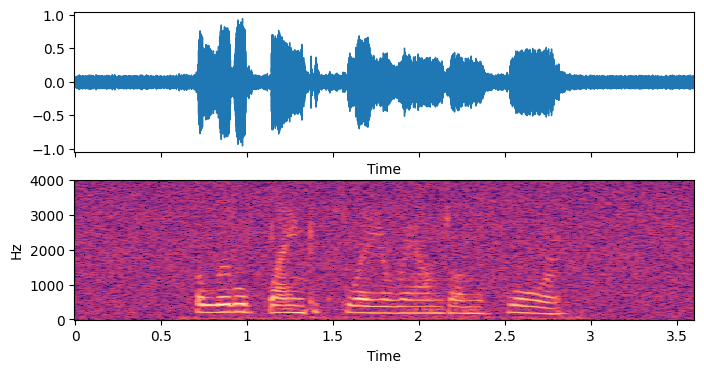

In [782]:
# Original noisy speech 
plot_speech(y, sr=sr, frm_len=frame_size, hop_len=frame_shift)

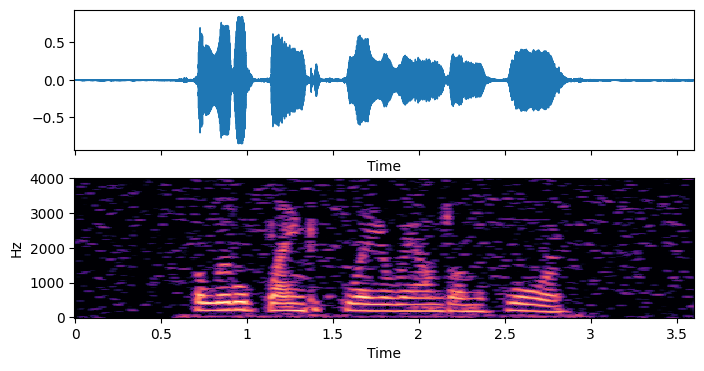

In [783]:
# Denoised speech
plot_speech(x, sr=sr, frm_len=frame_size, hop_len=frame_shift)

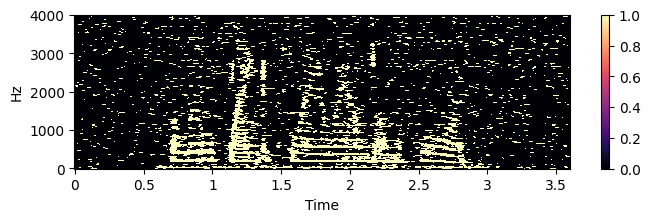

In [784]:
# Plot the mask showing the frequencies and frames at which the spectral components (in black) 
# go negative after subtraction.
plt.figure(figsize=(8,2))
librosa.display.specshow(mask, sr=sr, n_fft=frame_size, hop_length=frame_shift, x_axis='time', y_axis='linear')
plt.colorbar()

In [785]:
# Listen to the noisy speech
Audio(data=y, rate=sr)

In [786]:
# Listen to the denoised speech
Audio(data=x, rate=sr)

Add non-stationary noise to clean a speech file to create a noisy speech file. Then, apply spectral subtraction to denoise the noisy speech.

In [787]:
# Load clean speech and noise files
from itertools import cycle, islice
clean_speech_file = '../AudioFiles/clean_speech.wav'
noise_file = '../AudioFiles/machine-gun.mp3'
clean, sr = librosa.load(clean_speech_file, sr=None, mono=True) # keep native sr (sampling rate) and trans into mono
noise, fs = librosa.load(noise_file, sr=None, mono=True)
noise = librosa.resample(noise, orig_sr=fs, target_sr=sr)
noise = np.array(list(islice(cycle(noise), clean.shape[0])))
y = clean + 0.2*noise

In [788]:
# Perform spectral subtraction
x, X, mask = specsub(y, frame_size=frame_size, frame_shift=frame_shift, sr=sr)

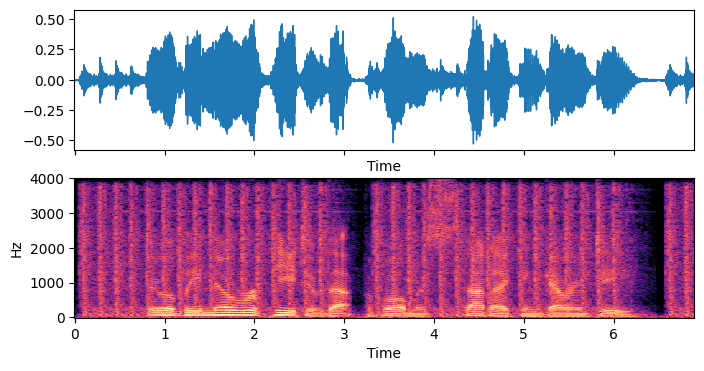

In [789]:
plot_speech(y, frm_len=frame_size, hop_len=frame_shift)

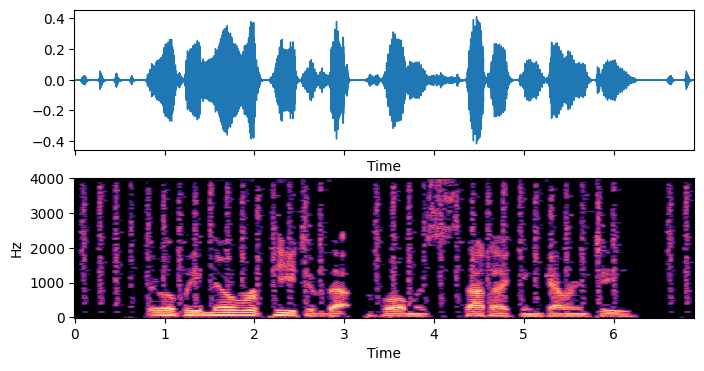

In [790]:
# Denoised speech
plot_speech(x, frm_len=frame_size, hop_len=frame_shift)

In [791]:
# Listen to the noisy speech
Audio(data=y, rate=sr)

In [792]:
# Listen to the denoised speech
Audio(data=x, rate=sr)